In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader, get_train_dataloader

# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline


# with open("./configs/ganomaly_config.yaml", "r") as f:
with open("./configs/ganomaly_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])


Global seed set to 42


img_csv='./data/splits/absent_septum.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/artefacts.csv' 
 len(self.img_paths)=16
img_csv='./data/splits/craniatomy.csv' 
 len(self.img_paths)=15
img_csv='./data/splits/dural.csv' 
 len(self.img_paths)=7
img_csv='./data/splits/ea_mass.csv' 
 len(self.img_paths)=4
img_csv='./data/splits/edema.csv' 
 len(self.img_paths)=18
img_csv='./data/splits/encephalomalacia.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/enlarged_ventricles.csv' 
 len(self.img_paths)=19
img_csv='./data/splits/intraventricular.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/lesions.csv' 
 len(self.img_paths)=22
img_csv='./data/splits/mass.csv' 
 len(self.img_paths)=22
img_csv='./data/splits/posttreatment.csv' 
 len(self.img_paths)=44
img_csv='./data/splits/resection.csv' 
 len(self.img_paths)=10
img_csv='./data/splits/sinus.csv' 
 len(self.img_paths)=2
img_csv='./data/splits/wml.csv' 
 len(self.img_paths)=5
img_csv='./data/splits/other.csv' 
 len(self.img_paths)=

In [2]:
# load model from checkpit
from model.ganomaly.lightning_model import Ganomaly


model = get_model(config)
# Specify the path to your checkpoint file
# checkpoint_path = '/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_4/checkpoints/epoch=49-step=300.ckpt'
#latent512
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_5/checkpoints/epoch=49-step=400.ckpt"
# latent 1024
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_6/checkpoints/epoch=99-step=800.ckpt"
# extra lyers:2 latent 1248?
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_11/checkpoints/epoch=99-step=1200.ckpt"
# 2048, 1 extra layer
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_12/checkpoints/epoch=55-step=672.ckpt"
# 4096, 1 extra layer
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_13/checkpoints/epoch=51-step=624.ckpt"
# 64x64!. 8192, 2 extra layer
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_20/checkpoints/epoch=22-step=138.ckpt"
# 64x64!. 2048, 1 extra layer, nf32
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_22/checkpoints/epoch=139-step=560.ckpt"
# 64x64!. 2048, 3 extra layer, nf64
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_24/checkpoints/epoch=105-step=636.ckpt"
# 64x64!. 1024, 3 extra layer, nf32
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_25/checkpoints/epoch=149-step=900.ckpt"
# 64x64!. 512, 3 extra layer, nf64
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_29/checkpoints/epoch=149-step=600.ckpt"
# 64x64!. 512, 3 extra layer, nf64,wadv: 5 wcon: 60 wenc: 1
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_30/checkpoints/epoch=149-step=600.ckpt"
# other ws
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_32/checkpoints/epoch=65-step=396.ckpt"
# 64x64!. 1025, 0 el, nf 32, wcon 50 other w's 0
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_34/checkpoints/epoch=149-step=600.ckpt"
# target_size: !<tag:yaml.org,2002:seq> [64,64] batch_size: 512 latent_vec_size : 2000 n_features: 32 lr: 0.004 num_epochs: 150 extra_layers: 0 wadv: 1 wcon: 50 wenc: 1
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_36/checkpoints/epoch=149-step=600.ckpt"
#target_size: !<tag:yaml.org,2002:seq> [64,64] batch_size: 2000 latent_vec_size : 1000 n_features: 32 lr: 0.004 num_epochs: 150 extra_layers: 0 wadv: 1 wcon: 50 wenc: 1
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_37/checkpoints/epoch=149-step=300.ckpt"
# target_size: !<tag:yaml.org,2002:seq> [32,32] batch_size: 2000 latent_vec_size : 200 n_features: 32 lr: 0.004 num_epochs: 150 extra_layers: 0 wadv: 1 wcon: 50 wenc: 1
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_38/checkpoints/epoch=149-step=300.ckpt"
# target_size: !<tag:yaml.org,2002:seq> [64,64] batch_size: 2000 latent_vec_size : 256 n_features: 32 lr: 0.004 num_epochs: 150 extra_layers: 0 wadv: 1 wcon: 50 wenc: 1
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_39/checkpoints/epoch=149-step=300.ckpt"
# target_size: !<tag:yaml.org,2002:seq> [64,64] batch_size: 512 latent_vec_size : 512 n_features: 64 lr: 0.004 num_epochs: 150 extra_layers: 2 wadv: 1 wcon: 50 wenc: 1
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_40/checkpoints/epoch=149-step=600.ckpt"
# target_size: !<tag:yaml.org,2002:seq> [64,64] batch_size: 64 latent_vec_size : 1024 n_features: 128 lr: 0.004 num_epochs: 150 extra_layers: 5 wadv: 1 wcon: 50 wenc: 1 kernel_size: 4
# checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_43/checkpoints/epoch=149-step=3600.ckpt"

# target_size: !<tag:yaml.org,2002:seq> [64,64] batch_size: 40 latent_vec_size : 4096 n_features: 140 lr: 0.004 num_epochs: 150 extra_layers: 4 wadv: 2 wcon: 50 wenc: 1 kernel_size: 4
checkpoint_path = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_49/checkpoints/epoch=120-step=4356.ckpt"#"/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_49/checkpoints/epoch=149-step=5400.ckpt"

# Initialize the model by loading from the checkpoint
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])


Loading model ganomaly


<All keys matched successfully>

In [3]:
from ganomaly_eval import  GanomalyEvaluator, EvalType
normal_test_dataloader = get_normal_test_dataloader(config['split_dir'], config['target_size'], config['batch_size'])
train_dataloader = get_train_dataloader(config['split_dir'], config['target_size'], config['batch_size'])
all_data_loaders = test_dataloaders.copy()
all_data_loaders.update({"normal":normal_test_dataloader})


evaluator = GanomalyEvaluator(model, all_data_loaders)
evaluator.evaluate_model(normalize=True)

train_evaluator = GanomalyEvaluator(model, {"train":train_dataloader})
train_evaluator.evaluate_model(normalize=True)

img_csv='./data/splits/normal_test.csv' 
 len(self.img_paths)=30


## Stats

In [4]:
# evaluator.normalize_scores()
evaluator.print_stats_table()

                    Statistics of Anomaly Scores per categroy                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology           ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ absent_septum       │    0.14 │    0.14 │   0.14 │ 0.14 │     0.00 │        1 │
│ artefacts           │    0.00 │    0.49 │   0.03 │ 0.06 │     0.01 │       16 │
│ craniatomy          │    0.00 │    0.56 │   0.01 │ 0.12 │     0.03 │       15 │
│ dural               │    0.01 │    0.17 │   0.01 │ 0.05 │     0.00 │        7 │
│ ea_mass             │    0.01 │    0.26 │   0.02 │ 0.08 │     0.01 │        4 │
│ edema               │    0.00 │    0.77 │   0.03 │ 0.13 │     0.04 │       18 │
│ encephalomalacia    │    0.20 │    0.20 │   0.20 │ 0.20 │     0.00 │        1 │
│ enlarged_ventricles │    0.00 │    0.88 │   0.03 │ 0.10 │     0.04 │       19 │
│ intraventricular    │    0.34 │    0.34 │   0.34 │ 0.34 │     0.00 │        1 │
│ lesions             │    0.00 │    0.49 │   0.02 │ 0.06 │     0.01 │       22 │
│ mass                │    0.01 │    0.65 │   0.01 │ 0.11 │     0.03 │       22 │
│ posttreatment       │    0.00 │    1.00 │   0.03 │ 0.11 │     0.04 │       44 │
│ resection           │    0.01 │    0.77 │   0.02 │ 0.19 │     0.09 │       10 │
│ sinus               │    0.01 │    0.23 │   0.12 │ 0.12 │     0.01 │        2 │
│ wml                 │    0.00 │    0.10 │   0.08 │ 0.06 │     0.00 │        5 │
│ other               │    0.01 │    0.33 │   0.03 │ 0.12 │     0.02 │        5 │
│ normal              │    0.00 │    0.53 │   0.03 │ 0.08 │     0.02 │       30 │
└─────────────────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

In [5]:
train_evaluator.print_stats_table()

               Statistics of Anomaly Scores per categroy               
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ train     │    0.00 │    1.00 │   0.06 │ 0.08 │     0.01 │      711 │
└───────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

## Histograms

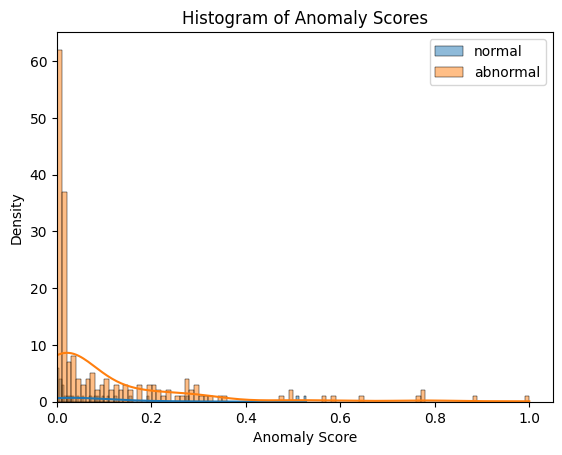

In [6]:
evaluator.histplot()

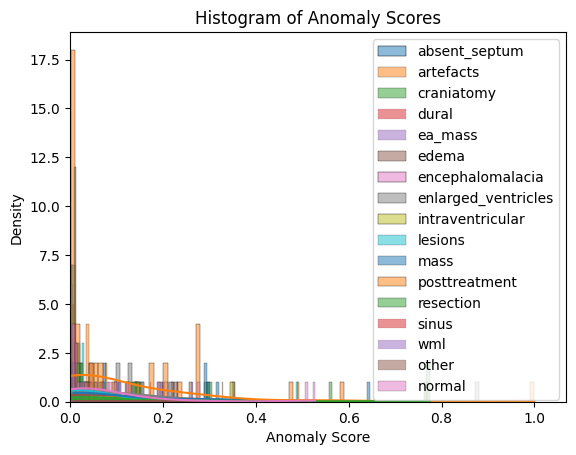

In [7]:
evaluator.histplot(eval_type=EvalType.ALL)

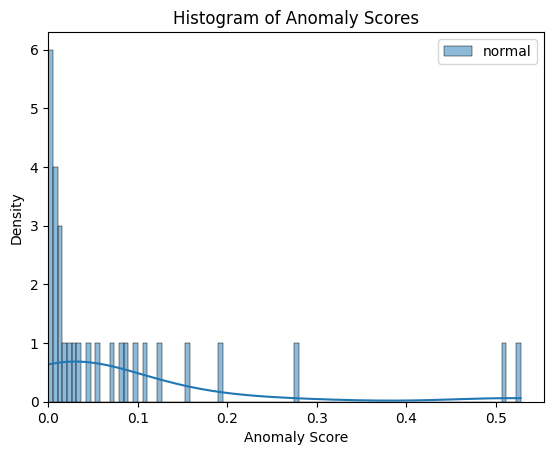

In [8]:
evaluator.histplot(EvalType.NORMAL)

tra

# Metrics

## Find optimal threshold

In [9]:
optimal_threshold = evaluator.find_optimal_threshold_f1()
print(optimal_threshold)
if optimal_threshold == 0:
    optimal_threshold = 0.03

0.00072175136


## General classification report

In [10]:
evaluator.classification_report(threshold=optimal_threshold)

              precision    recall  f1-score   support

           0       0.50      0.03      0.06        30
           1       0.87      0.99      0.93       192

    accuracy                           0.86       222
   macro avg       0.68      0.51      0.49       222
weighted avg       0.82      0.86      0.81       222



## Confusion matrix

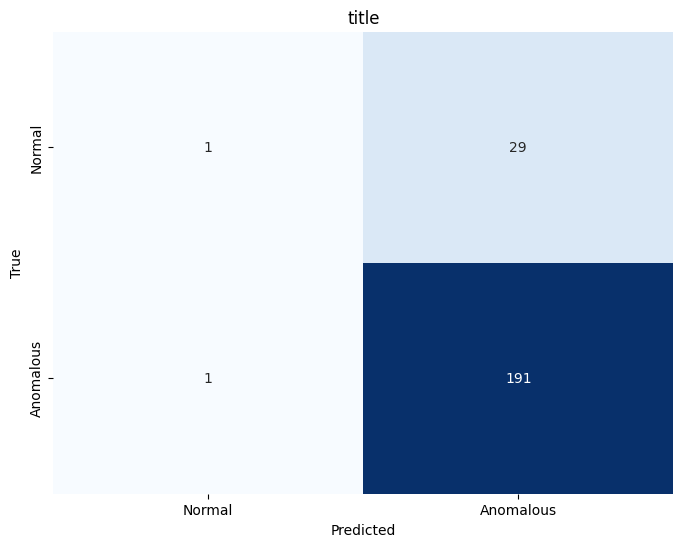

In [11]:
evaluator.plot_confusion_matrix(threshold=optimal_threshold)

## AUROC

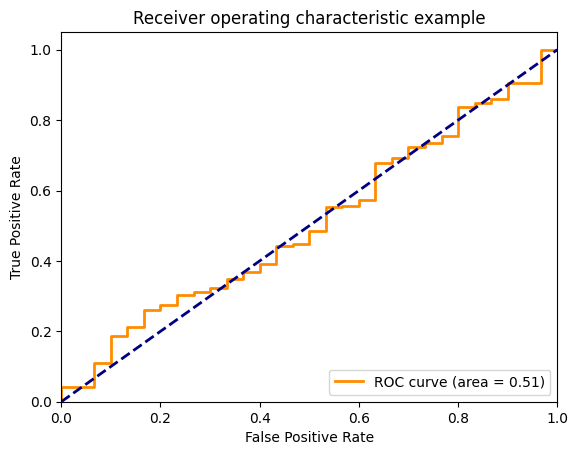

In [12]:
# evaluator.roc_auc_score()
evaluator.plot_auroc()

## PRC AUC

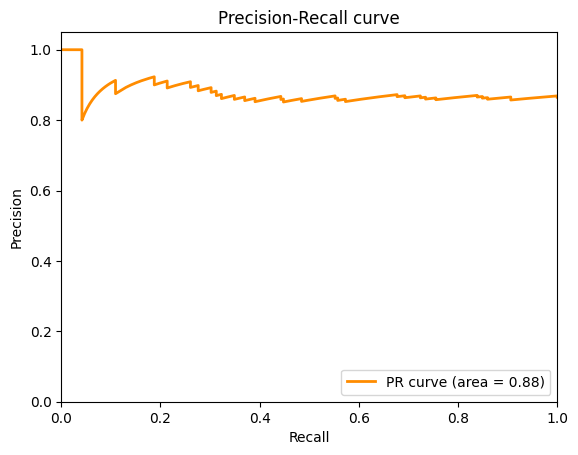

In [13]:
# evaluator.prc_auc_score()
evaluator.plot_auprc()

# Reconstructions

## Test set - Normal data

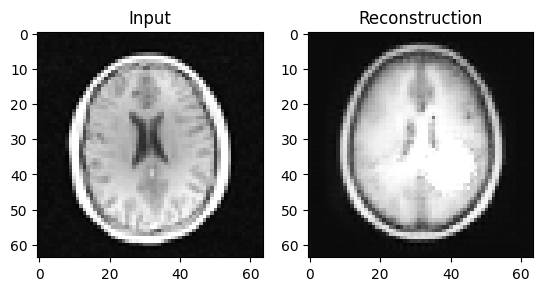

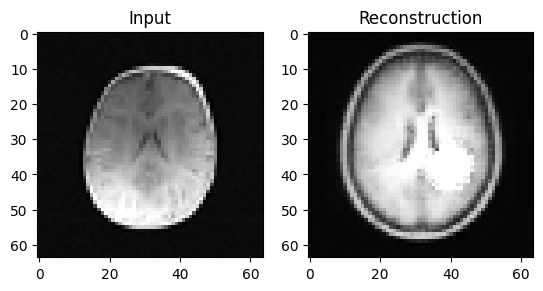

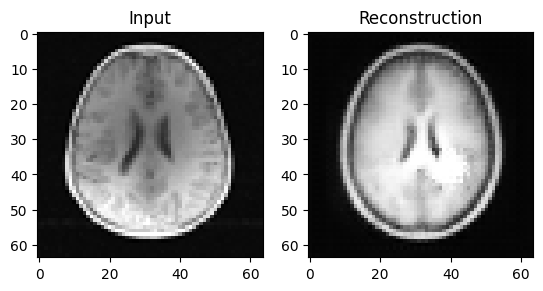

In [14]:
evaluator.plot_in_rec(label="normal", n=3)

## Recon for normal train data

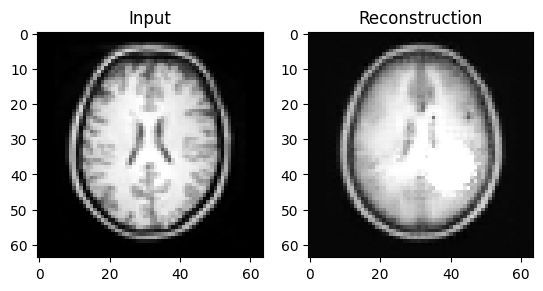

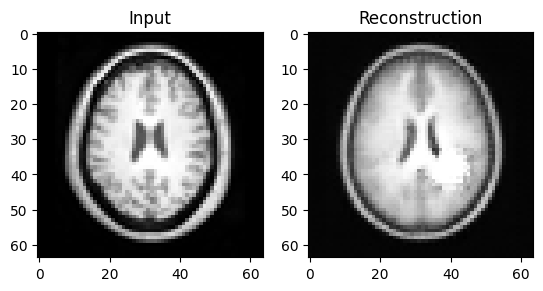

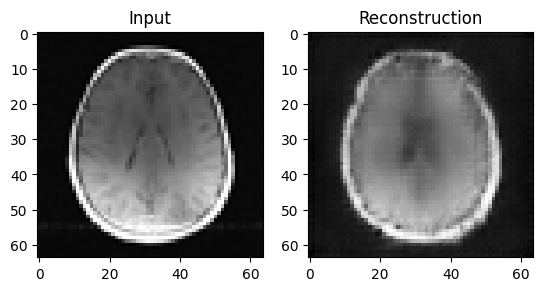

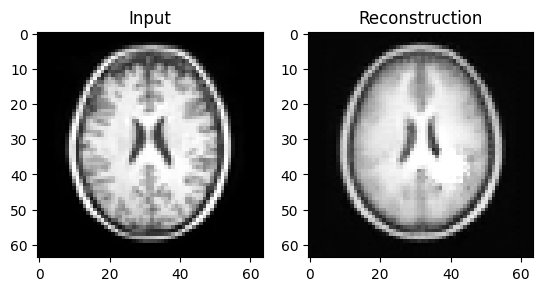

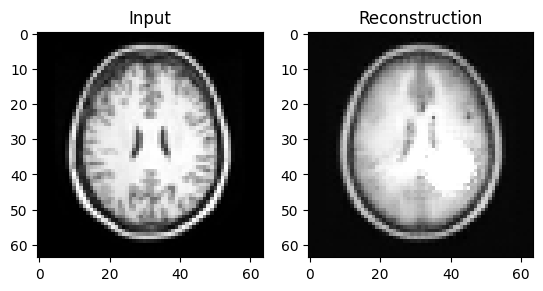

In [15]:
train_evaluator.plot_in_rec(label="train", n=5)

## Recon for abnormal

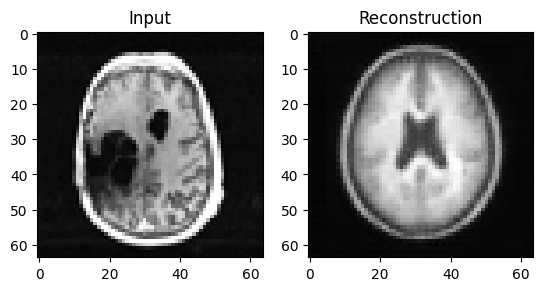

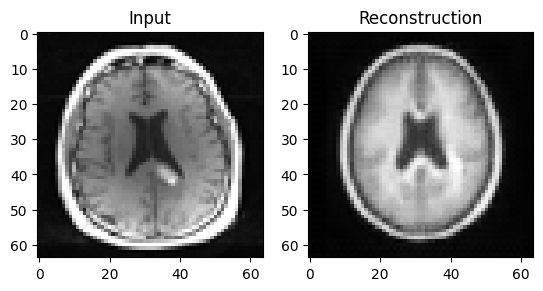

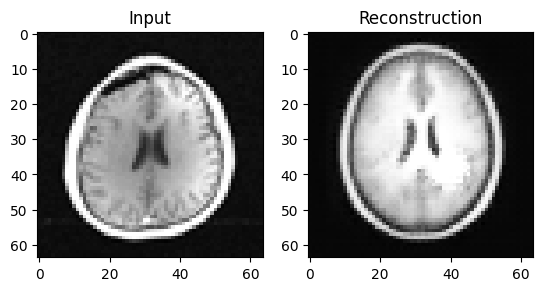

In [16]:
evaluator.plot_in_rec(label="resection", n=3)

In [17]:
# fig_example.savefig(f"example_{config['num_epochs']}.png")